# Statistics Project
## Impact of Oil Prices on Airline Revenue:
### A Comparative Analysis of Oil-Producing vs Non-Oil-Producing Airlines

# Load Data and import libraray 

In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller


file_path = r"C:\Users\Sai kumar\ARO_project\data\19DCE620.xlsx"
xls = pd.ExcelFile(file_path)
dfs = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in xls.sheet_names}
print("Sheets in file:", list(dfs.keys()))



Sheets in file: ['Indigo', 'Singapore Airlines', 'Air Canada', 'Delta Airlines']


#  ADF Test for stationarity

###  Differencing to make data stationary
### Combine all airlines into panel dataset

In [24]:

def adf_check(series, name):
    """Perform ADF Test to check if the series is stationary."""
    result = adfuller(series.dropna())
    print(f"\nADF Test - {name}")
    print("ADF Statistic:", round(result[0], 4))
    print("p-value:", round(result[1], 4))
    if result[1] < 0.05:
        print(" Stationary")
    else:
        print(" Non-stationary")

for name, df in dfs.items():
    adf_check(df["Real Brent Crude"], f"{name} - Crude")
    adf_check(df["Revenue"], f"{name} - Revenue")

for name, df in dfs.items():
    df["dCrude"] = df["Real Brent Crude"].diff()
    df["dRevenue"] = df["Revenue"].diff()
    dfs[name] = df.dropna(subset=["dCrude", "dRevenue"])

print("\n Differencing done to remove trend and make data stationary.")


panel = pd.concat([df.assign(Airline=name) for name, df in dfs.items()], ignore_index=True)

# Create dummy variable for oil-producing airlines
panel["OilProducer"] = panel["Airline"].apply(lambda x: 1 if x in ["Delta Airlines", "Air Canada"] else 0)
# Create interaction term
panel["Interaction"] = panel["dCrude"] * panel["OilProducer"]
# Create lag variable
panel["dCrude_lag1"] = panel.groupby("Airline")["dCrude"].shift(1)
panel = panel.dropna(subset=["dCrude_lag1"])

print("\n Combined panel dataset ready.")
print(panel.head())


ADF Test - Indigo - Crude
ADF Statistic: -2.4122
p-value: 0.1383
 Non-stationary

ADF Test - Indigo - Revenue
ADF Statistic: -2.257
p-value: 0.1862
 Non-stationary

ADF Test - Singapore Airlines - Crude
ADF Statistic: -2.4122
p-value: 0.1383
 Non-stationary

ADF Test - Singapore Airlines - Revenue
ADF Statistic: -1.2918
p-value: 0.6329
 Non-stationary

ADF Test - Air Canada - Crude
ADF Statistic: -2.4122
p-value: 0.1383
 Non-stationary

ADF Test - Air Canada - Revenue
ADF Statistic: -2.9929
p-value: 0.0356
 Stationary

ADF Test - Delta Airlines - Crude
ADF Statistic: -2.4122
p-value: 0.1383
 Non-stationary

ADF Test - Delta Airlines - Revenue
ADF Statistic: -2.3141
p-value: 0.1675
 Non-stationary

 Differencing done to remove trend and make data stationary.

 Combined panel dataset ready.
   Index  Real Yield  Real Brent Crude        Revenue  Log_Revenue  Log_Crude  \
1      3   19.073634         46.304852  209809.972201     5.321826   1.665627   
2      4   18.441441         50.04244

# Manual regression model (with lag and interaction)


=== Regression Results (Full Model) ===
Intercept: β=1374.2344, SE=8971.8470, t=0.153, p=0.8785
dCrude: β=2370.7102, SE=1326.7858, t=1.787, p=0.0762
Lag_dCrude: β=2446.4119, SE=922.8646, t=2.651, p=0.0090
OilProducer: β=-4222.3038, SE=12672.0553, t=-0.333, p=0.7395
Interaction: β=1669.6298, SE=1845.5880, t=0.905, p=0.3673
R² = 0.1575


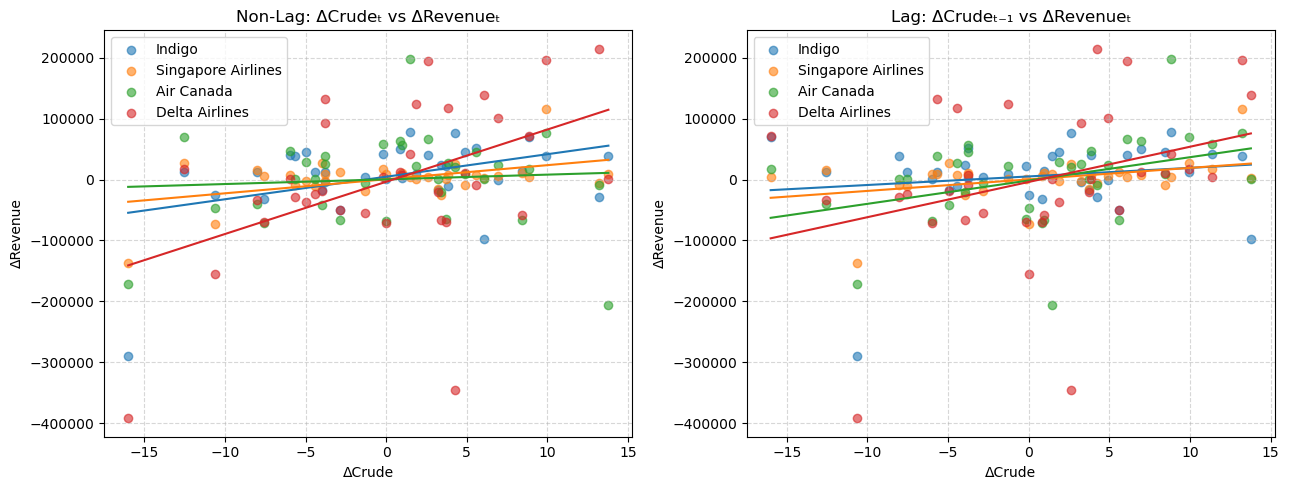

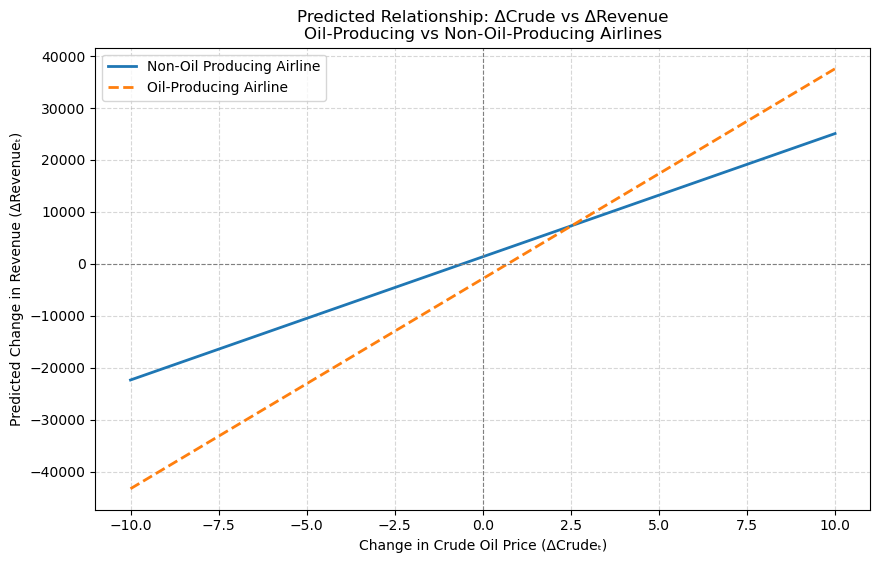

In [25]:

def manual_reg(y, X):
    """Perform linear regression manually using matrix algebra."""
    n, k = X.shape
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    y_pred = X @ beta
    resid = y - y_pred
    ssr = np.sum(resid**2)
    sst = np.sum((y - np.mean(y))**2)
    r2 = 1 - ssr/sst
    sigma2 = ssr / (n - k)
    var_b = sigma2 * np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(var_b)).reshape(-1, 1)
    t_vals = beta / se
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_vals), df=n - k))
    return beta, se, t_vals, p_vals, r2


y = panel["dRevenue"].values.reshape(-1, 1)
X = panel[["dCrude", "dCrude_lag1", "OilProducer", "Interaction"]].values
X = np.column_stack((np.ones(len(X)), X))

b, se, t, p, r2 = manual_reg(y, X)

cols = ["Intercept", "dCrude", "Lag_dCrude", "OilProducer", "Interaction"]
print("\n=== Regression Results (Full Model) ===")
for i in range(len(cols)):
    print(f"{cols[i]}: β={b[i][0]:.4f}, SE={se[i][0]:.4f}, t={t[i][0]:.3f}, p={p[i][0]:.4f}")
print("R² =", round(r2, 4))

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for airline in panel["Airline"].unique():
    sub = panel[panel["Airline"] == airline]
    # Non-lag relationship
    axes[0].scatter(sub["dCrude"], sub["dRevenue"], alpha=0.6, label=airline)
    X_sub = np.column_stack((np.ones(len(sub)), sub["dCrude"].values.reshape(-1, 1)))
    y_sub = sub["dRevenue"].values.reshape(-1, 1)
    b_sub, _, _, _, _ = manual_reg(y_sub, X_sub)
    x_vals = np.linspace(sub["dCrude"].min(), sub["dCrude"].max(), 50)
    y_line = b_sub[0][0] + b_sub[1][0] * x_vals
    axes[0].plot(x_vals, y_line)
    # Lag relationship
    axes[1].scatter(sub["dCrude_lag1"], sub["dRevenue"], alpha=0.6, label=airline)
    X_sub = np.column_stack((np.ones(len(sub)), sub["dCrude_lag1"].values.reshape(-1, 1)))
    b_sub, _, _, _, _ = manual_reg(y_sub, X_sub)
    x_vals = np.linspace(sub["dCrude_lag1"].min(), sub["dCrude_lag1"].max(), 50)
    y_line = b_sub[0][0] + b_sub[1][0] * x_vals
    axes[1].plot(x_vals, y_line)

axes[0].set_title("Non-Lag: ΔCrudeₜ vs ΔRevenueₜ")
axes[1].set_title("Lag: ΔCrudeₜ₋₁ vs ΔRevenueₜ")
for ax in axes:
    ax.set_xlabel("ΔCrude")
    ax.set_ylabel("ΔRevenue")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


crude_changes = np.linspace(-10, 10, 50)
beta_0, beta_1, beta_2, beta_3, beta_4 = b.flatten()

rev_non_oil = beta_0 + beta_1 * crude_changes
rev_oil = beta_0 + (beta_1 + beta_4) * crude_changes + beta_3

plt.figure(figsize=(10, 6))
plt.plot(crude_changes, rev_non_oil, label="Non-Oil Producing Airline", linewidth=2)
plt.plot(crude_changes, rev_oil, label="Oil-Producing Airline", linewidth=2, linestyle="--")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Predicted Relationship: ΔCrude vs ΔRevenue\nOil-Producing vs Non-Oil-Producing Airlines")
plt.xlabel("Change in Crude Oil Price (ΔCrudeₜ)")
plt.ylabel("Predicted Change in Revenue (ΔRevenueₜ)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# Individual Airline descriptive results 

In [26]:
print("\n=== Individual Airline Regressions (ΔRevenue ~ ΔCrude) ===")
rows = []
for airline in panel["Airline"].unique():
    sub = panel[panel["Airline"] == airline]
    y_sub = sub["dRevenue"].values.reshape(-1, 1)
    X_sub = np.column_stack((np.ones(len(sub)), sub["dCrude"].values.reshape(-1, 1)))
    b, se, t, p, r2 = manual_reg(y_sub, X_sub)
    rows.append({
        "Airline": airline,
        "Intercept": round(b[0][0], 4),
        "Slope": round(b[1][0], 4),
        "StdErr": round(se[1][0], 4),
        "t": round(t[1][0], 3),
        "p": round(p[1][0], 4),
        "R²": round(r2, 3)
    })

results = pd.DataFrame(rows)
print(results)

alpha = 0.05  # significance level

print("\n\n=== Hypothesis Testing: Does Crude Oil Price Affect Airline Revenue? ===")
for i, row in results.iterrows():
    if row["p"] < alpha:
        print(f"{row['Airline']}: p = {row['p']:.4f} → Reject H₀  (Significant effect)")
    else:
        print(f"{row['Airline']}: p = {row['p']:.4f} → Fail to Reject H₀  (Not significant)")

# Summary counts
sig_count = (results["p"] < alpha).sum()
total = len(results)

print(f"\nSummary: {sig_count} out of {total} airlines show a significant relationship "
      f"between crude oil price changes and revenue changes (p < 0.05).")

# Simple conclusion text
if sig_count == 0:
    print("\nConclusion: For all airlines, there is no strong statistical evidence "
          "that crude oil price changes affect revenue.")
elif sig_count < total:
    print("\nConclusion: Some airlines show a significant effect of crude oil prices on revenue, "
          "while others do not. This means the impact may differ depending on the airline's operations "
          "and whether it is oil-producing or not.")
else:
    print("\nConclusion: All airlines show a significant relationship between oil price changes "
          "and revenue. We reject the null hypothesis (H₀) and conclude that oil prices have "
          "a strong influence on airline yield.")



=== Individual Airline Regressions (ΔRevenue ~ ΔCrude) ===
              Airline  Intercept      Slope     StdErr      t       p     R²
0              Indigo  4624.0215  3698.9058  1442.2603  2.565  0.0151  0.166
1  Singapore Airlines   516.3996  2311.2141   792.2471  2.917  0.0063  0.205
2          Air Canada   350.2144   772.4237  1789.1744  0.432  0.6688  0.006
3      Delta Airlines -3654.4009  8576.9558  2791.3208  3.073  0.0042  0.222


=== Hypothesis Testing: Does Crude Oil Price Affect Airline Revenue? ===
Indigo: p = 0.0151 → Reject H₀  (Significant effect)
Singapore Airlines: p = 0.0063 → Reject H₀  (Significant effect)
Air Canada: p = 0.6688 → Fail to Reject H₀  (Not significant)
Delta Airlines: p = 0.0042 → Reject H₀  (Significant effect)

Summary: 3 out of 4 airlines show a significant relationship between crude oil price changes and revenue changes (p < 0.05).

Conclusion: Some airlines show a significant effect of crude oil prices on revenue, while others do not. This me